In [ ]:
%matplotlib inline


Transfer Learning for Computer Vision Tutorial
==============================================

Use the [dataset](http://chaladze.com/l5/) of 5 classes for this experiment.
<div style="float: left">
<img src="dataset-5.jpg">
</div>


In [ ]:
# !wget http://chaladze.com/l5/img/Linnaeus%205%20256X256.rar

In [ ]:
# !unrar x Linnaeus\ 5\ 256X256.rar

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.


In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images
---------------------
Let's visualize a few training images so as to understand the data
augmentations.



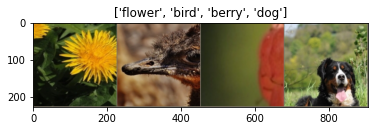

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
--------------------------------

Generic function to display predictions for a few images




In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [53]:
# model_ft = model_ft.to(device)
# for data,target in dataloaders["train"]:
#     d, t = data.to(device),target.to(device)
#     print(data.shape, target.shape)
#     feature = model_ft(d)
#     print(feature.shape)
#     break

In [94]:
# new_ft = new.to(device)
# for data,target in dataloaders["train"]:
#     d, t = data.to(device),target.to(device)
#     print(data.shape, target.shape)
#     feature = new_ft(d)
#     print(feature.shape)
#     break

torch.Size([4, 3, 224, 224]) torch.Size([4])
torch.Size([4, 512, 14, 14])


In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
----------------

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [156]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=1)

In [157]:
# %timeit -r1 -n1 train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=1)

In [158]:
# %timeit -r1 -n1 train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=1)

In [159]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [6]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 5)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
----

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [160]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

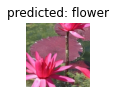

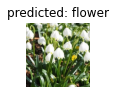

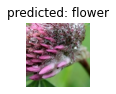

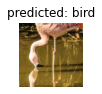

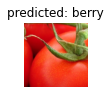

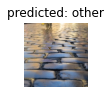

In [8]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Further Learning
-----------------

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html>`_.





# Extracting Features from the trained model

In [121]:
vgg16 = torchvision.models.vgg16(pretrained=True)

In [122]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Extract the features of the last CONV layer
---
To extract the features of the arbitrary layers or features from different parts of the pretrained model, we need to **recreate the model** and reusing the parts of the pretrained model in the new model.

In [125]:
class XVGGFeatures(nn.Module):
    def __init__(self, pretrained_model):
        super(XVGGFeatures, self).__init__()
        self.features = pretrained_model.features
        
    def forward(self, x):
        x = self.features(x)
        return x

In [128]:
# create the instance of the new model

model_new = XVGGFeatures(vgg16).to(device)

## Test the new model

In [129]:

for d, t in dataloaders["train"]:
    data, target = d.to(device),t.to(device)
    
    f = model_new(data)
    
    print(f.shape)
    break

torch.Size([4, 512, 7, 7])


## Extract features from last second CONV layer
---


In [154]:
class LastSecondConv(nn.Module):
    def __init__(self, pretrained):
        super(LastSecondConv, self).__init__()
        self.features = nn.Sequential(*list(pretrained.features.children())[:-4]) #upto ReLU layer
        
    def forward(self, x):
        x=self.features(x)
        return x

## Test the model

In [155]:
lsec_model = LastSecondConv(vgg16)
model = lsec_model.to(device)
for d, t in dataloaders["train"]:
    data, target = d.to(device),t.to(device)
    
    f = model(data)
    
    print(f.shape)
    break

torch.Size([4, 512, 14, 14])


# Working with `nn.ModuleDict`

In [175]:
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule,self).__init__()
        self.choices = nn.ModuleDict({"conv":nn.Conv2d(3,10,3), "pool": nn.MaxPool2d(3)})
        self.activations = nn.ModuleDict([['lrelu',nn.LeakyReLU()],['prelu',nn.PReLU()]])
    def forward(self,x,choices,act):
        x = self.choices[choices](x)
        x = self.activations[act](x)
        return x

## Test the model

In [180]:
it=iter(dataloaders["train"])

In [181]:
d,t = it.next()

In [184]:
# creating the instance
model_dict = MyModule()

In [185]:
out = model_dict(d,"pool","lrelu")

## Working with `nn.ModuleList`

In [188]:
class MyModuleList(nn.Module):
    def __init__(self):
        super(MyModuleList,self).__init__()
        self.linears = nn.ModuleList([nn.Linear(10,10) for i in range(10)])
        
    def forward(self,x):
        # ModuleList can act as n iterable, or be indexed using ints
        for i, l in enumerate(self.linears):
            x = self.linears[i//2](x)+l(x)
        return x

## Testing the model

In [190]:
x = torch.randn(1,10)

In [192]:
obj = MyModuleList()

print(obj(x))

tensor([[-0.1776,  1.3353, -0.6448,  0.6973, -0.0127, -0.4297, -0.0288,  0.4922,
          0.5554,  0.2952]], grad_fn=<AddBackward0>)
